In [1]:
import sys
import os
sys.path.append(os.path.abspath("../.."))

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import random
import time

from models.lstm import LSTMRegressor
from utils.stock_data import get_log_return_loaders, StockIndex
from utils.early_stopping import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


Using device: cuda


In [2]:
window_size = 7

BEST_LSTM_PARAMS = {
    StockIndex.NVDA: {
        "hidden_dim": 192,
        "num_layers": 3,
        "dropout": 0.22832671613107025,
        "batch_size": 16,
        "lr": 0.001025807645705379
    },
    StockIndex.AAPL: {
        "hidden_dim": 32,
        "num_layers": 2,
        "dropout": 0.1879585812618099,
        "batch_size": 64,
        "lr": 0.00016388823896781193
    },
    StockIndex.KO: {
        "hidden_dim": 32,
        "num_layers": 1,
        "dropout": 0.15532586065977919,
        "batch_size": 64,
        "lr": 0.0010746245334922824
    }
}

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


## Training Baseline LSTM for each stock ##


### NVIDIA ###

In [8]:
stock = StockIndex.NVDA
lstm_params = BEST_LSTM_PARAMS[stock]
train_dl, val_dl, test_dl = get_log_return_loaders(
    stock,
    window_size=7,
    batch_size=lstm_params["batch_size"]
)
input_dim = next(iter(train_dl))[0].shape[-1]

Epoch 1: Train Loss = 0.001181 | Val Loss = 0.000690
Epoch 2: Train Loss = 0.001128 | Val Loss = 0.000689
Epoch 3: Train Loss = 0.001115 | Val Loss = 0.000691
Epoch 4: Train Loss = 0.001109 | Val Loss = 0.000690
Epoch 5: Train Loss = 0.001107 | Val Loss = 0.000790
Epoch 6: Train Loss = 0.001110 | Val Loss = 0.000684
Epoch 7: Train Loss = 0.001129 | Val Loss = 0.000695
Epoch 8: Train Loss = 0.001101 | Val Loss = 0.000739
Epoch 9: Train Loss = 0.001098 | Val Loss = 0.000688
Epoch 10: Train Loss = 0.001099 | Val Loss = 0.000712
Epoch 11: Train Loss = 0.001091 | Val Loss = 0.000717
Epoch 12: Train Loss = 0.001105 | Val Loss = 0.000697
Epoch 13: Train Loss = 0.001089 | Val Loss = 0.000688
Epoch 14: Train Loss = 0.001083 | Val Loss = 0.000683
Epoch 15: Train Loss = 0.001085 | Val Loss = 0.000690
Epoch 16: Train Loss = 0.001068 | Val Loss = 0.000684
Epoch 17: Train Loss = 0.001075 | Val Loss = 0.000686
Epoch 18: Train Loss = 0.001073 | Val Loss = 0.000686
Epoch 19: Train Loss = 0.001065 | Val

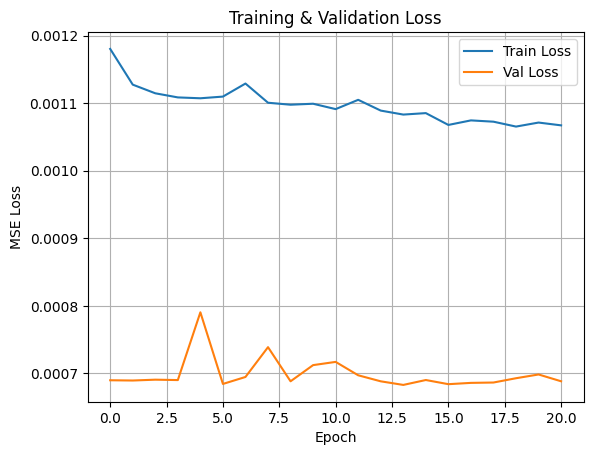

In [4]:
nvda_model = LSTMRegressor(
    input_dim=input_dim,
    hidden_dim=lstm_params['hidden_dim'],
    num_layers=lstm_params['num_layers'],
    dropout=lstm_params['dropout']
).to(device)

optimizer = optim.Adam(nvda_model.parameters(), lr=lstm_params['lr'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
criterion = nn.MSELoss()
early_stopper = EarlyStopping(patience=20, min_delta=1e-5)

train_losses = []
val_losses = []

for epoch in range(50):
    # ---- TRAIN ----
    nvda_model.train()
    train_loss = 0
    for xb, yb, _ in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(nvda_model(xb).squeeze(), yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_dl)
    train_losses.append(train_loss)

    # ---- VALIDATE ----
    nvda_model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb, _ in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            val_loss += criterion(nvda_model(xb).squeeze(), yb).item()
    val_loss /= len(val_dl)
    val_losses.append(val_loss)

    scheduler.step(val_loss)
    early_stopper(val_loss)

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.6f} | Val Loss = {val_loss:.6f}")

    if early_stopper.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# Plot training + validation loss
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.legend()
plt.show()


Mean predicted return: 0.002502646
Std of predicted return: 0.0026598976
Mean actual return: 0.002643923
Std of actual return: 0.032575168
Test RMSE: 3.8778
Test MAE : 3.0223


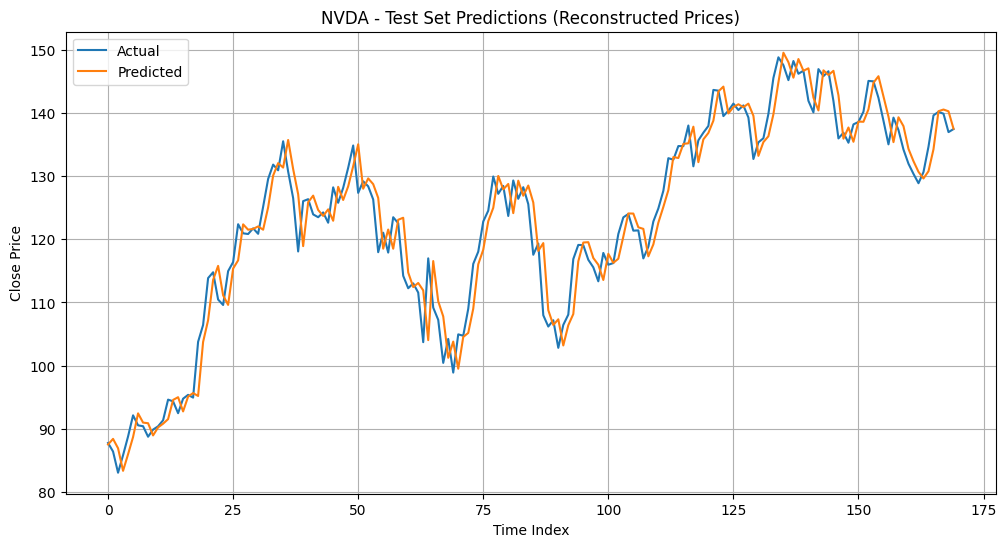

In [5]:
nvda_model.eval()
preds, targets, prev_prices = [], [], []

with torch.no_grad():
    for xb, yb, p_tm1 in test_dl:
        xb = xb.to(device)
        y_pred = nvda_model(xb).squeeze().cpu().numpy()

        preds.extend(y_pred)
        targets.extend(yb.numpy())
        prev_prices.extend(p_tm1.numpy())

preds = np.array(preds)
targets = np.array(targets)
prev_prices = np.array(prev_prices)

# Reconstruct actual prices
pred_prices = prev_prices * np.exp(preds)
true_prices = prev_prices * np.exp(targets)

print("Mean predicted return:", np.mean(preds))
print("Std of predicted return:", np.std(preds))

print("Mean actual return:", np.mean(targets))
print("Std of actual return:", np.std(targets))

# Metrics
rmse = np.sqrt(mean_squared_error(true_prices, pred_prices))
mae = mean_absolute_error(true_prices, pred_prices)
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE : {mae:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(true_prices, label="Actual")
plt.plot(pred_prices, label="Predicted")
plt.title(f"{stock.value} - Test Set Predictions (Reconstructed Prices)")
plt.xlabel("Time Index")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()



### APPLE ###

In [6]:
stock = StockIndex.AAPL
lstm_params = BEST_LSTM_PARAMS[stock]
train_dl, val_dl, test_dl = get_log_return_loaders(
    stock,
    window_size=7,
    batch_size=lstm_params["batch_size"]
)
input_dim = next(iter(train_dl))[0].shape[-1]

Epoch 1: Train Loss = 0.012284 | Val Loss = 0.006226
Epoch 2: Train Loss = 0.003427 | Val Loss = 0.000966
Epoch 3: Train Loss = 0.000750 | Val Loss = 0.000224
Epoch 4: Train Loss = 0.000528 | Val Loss = 0.000223
Epoch 5: Train Loss = 0.000551 | Val Loss = 0.000223
Epoch 6: Train Loss = 0.000543 | Val Loss = 0.000216
Epoch 7: Train Loss = 0.000542 | Val Loss = 0.000211
Epoch 8: Train Loss = 0.000522 | Val Loss = 0.000209
Epoch 9: Train Loss = 0.000535 | Val Loss = 0.000205
Epoch 10: Train Loss = 0.000514 | Val Loss = 0.000202
Epoch 11: Train Loss = 0.000544 | Val Loss = 0.000200
Epoch 12: Train Loss = 0.000521 | Val Loss = 0.000197
Epoch 13: Train Loss = 0.000528 | Val Loss = 0.000193
Epoch 14: Train Loss = 0.000509 | Val Loss = 0.000193
Epoch 15: Train Loss = 0.000521 | Val Loss = 0.000188
Epoch 16: Train Loss = 0.000503 | Val Loss = 0.000187
Epoch 17: Train Loss = 0.000506 | Val Loss = 0.000184
Epoch 18: Train Loss = 0.000507 | Val Loss = 0.000182
Epoch 19: Train Loss = 0.000508 | Val

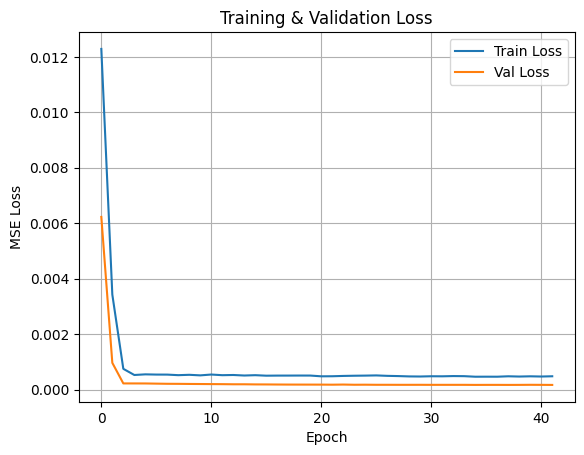

In [7]:
aapl_model = LSTMRegressor(
    input_dim=input_dim,
    hidden_dim=lstm_params['hidden_dim'],
    num_layers=lstm_params['num_layers'],
    dropout=lstm_params['dropout']
).to(device)

optimizer = optim.Adam(aapl_model.parameters(), lr=lstm_params['lr'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
criterion = nn.MSELoss()
early_stopper = EarlyStopping(patience=20, min_delta=1e-5)

train_losses = []
val_losses = []

for epoch in range(50):
    # ---- TRAIN ----
    aapl_model.train()
    train_loss = 0
    for xb, yb, _ in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(aapl_model(xb).squeeze(), yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_dl)
    train_losses.append(train_loss)

    # ---- VALIDATE ----
    aapl_model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb, _ in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            val_loss += criterion(aapl_model(xb).squeeze(), yb).item()
    val_loss /= len(val_dl)
    val_losses.append(val_loss)

    scheduler.step(val_loss)
    early_stopper(val_loss)

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.6f} | Val Loss = {val_loss:.6f}")

    if early_stopper.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# Plot training + validation loss
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.legend()
plt.show()


Mean predicted return: 0.00045262676
Std of predicted return: 0.00086378993
Mean actual return: 0.002365659
Std of actual return: 0.014482381
Test RMSE: 3.1119
Test MAE : 2.2595


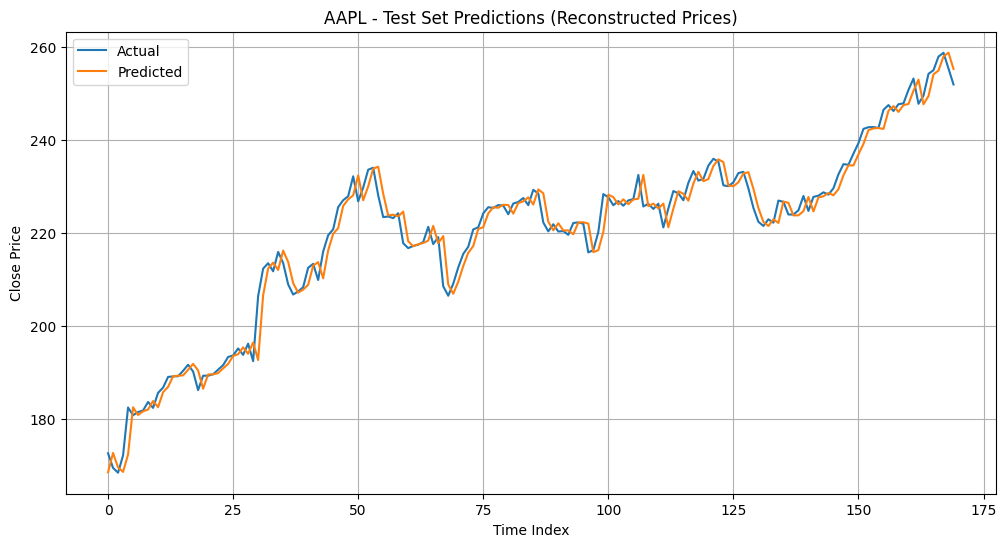

In [8]:
aapl_model.eval()
preds, targets, prev_prices = [], [], []

with torch.no_grad():
    for xb, yb, p_tm1 in test_dl:
        xb = xb.to(device)
        y_pred = aapl_model(xb).squeeze().cpu().numpy()

        preds.extend(y_pred)
        targets.extend(yb.numpy())
        prev_prices.extend(p_tm1.numpy())

preds = np.array(preds)
targets = np.array(targets)
prev_prices = np.array(prev_prices)

# Reconstruct actual prices
pred_prices = prev_prices * np.exp(preds)
true_prices = prev_prices * np.exp(targets)

print("Mean predicted return:", np.mean(preds))
print("Std of predicted return:", np.std(preds))

print("Mean actual return:", np.mean(targets))
print("Std of actual return:", np.std(targets))

# Metrics
rmse = np.sqrt(mean_squared_error(true_prices, pred_prices))
mae = mean_absolute_error(true_prices, pred_prices)
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE : {mae:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(true_prices, label="Actual")
plt.plot(pred_prices, label="Predicted")
plt.title(f"{stock.value} - Test Set Predictions (Reconstructed Prices)")
plt.xlabel("Time Index")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()

### COKE ###

In [3]:
stock = StockIndex.KO
lstm_params = BEST_LSTM_PARAMS[stock]
train_dl, val_dl, test_dl = get_log_return_loaders(
    stock,
    window_size=7,
    batch_size=lstm_params["batch_size"]
)
input_dim = next(iter(train_dl))[0].shape[-1]

Epoch 1: Train Loss = 0.000285 | Val Loss = 0.000123
Epoch 2: Train Loss = 0.000184 | Val Loss = 0.000072
Epoch 3: Train Loss = 0.000176 | Val Loss = 0.000076
Epoch 4: Train Loss = 0.000176 | Val Loss = 0.000072
Epoch 5: Train Loss = 0.000177 | Val Loss = 0.000071
Epoch 6: Train Loss = 0.000176 | Val Loss = 0.000071
Epoch 7: Train Loss = 0.000175 | Val Loss = 0.000071
Epoch 8: Train Loss = 0.000178 | Val Loss = 0.000071
Epoch 9: Train Loss = 0.000175 | Val Loss = 0.000072
Epoch 10: Train Loss = 0.000175 | Val Loss = 0.000081
Epoch 11: Train Loss = 0.000179 | Val Loss = 0.000075
Epoch 12: Train Loss = 0.000175 | Val Loss = 0.000072
Epoch 13: Train Loss = 0.000180 | Val Loss = 0.000074
Epoch 14: Train Loss = 0.000173 | Val Loss = 0.000072
Epoch 15: Train Loss = 0.000175 | Val Loss = 0.000072
Epoch 16: Train Loss = 0.000173 | Val Loss = 0.000074
Epoch 17: Train Loss = 0.000174 | Val Loss = 0.000071
Epoch 18: Train Loss = 0.000174 | Val Loss = 0.000072
Epoch 19: Train Loss = 0.000173 | Val

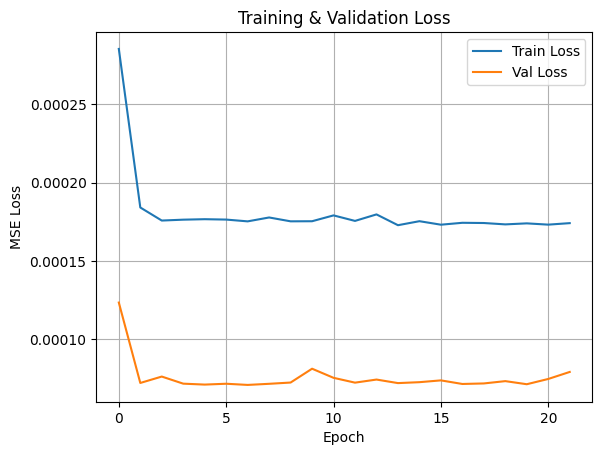

In [4]:
ko_model = LSTMRegressor(
    input_dim=input_dim,
    hidden_dim=lstm_params['hidden_dim'],
    num_layers=lstm_params['num_layers'],
    dropout=lstm_params['dropout']
).to(device)

optimizer = optim.Adam(ko_model.parameters(), lr=lstm_params['lr'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
criterion = nn.MSELoss()
early_stopper = EarlyStopping(patience=20, min_delta=1e-5)

train_losses = []
val_losses = []

for epoch in range(50):
    # ---- TRAIN ----
    ko_model.train()
    train_loss = 0
    for xb, yb, _ in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(ko_model(xb).squeeze(), yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_dl)
    train_losses.append(train_loss)

    # ---- VALIDATE ----
    ko_model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb, _ in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            val_loss += criterion(ko_model(xb).squeeze(), yb).item()
    val_loss /= len(val_dl)
    val_losses.append(val_loss)

    scheduler.step(val_loss)
    early_stopper(val_loss)

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.6f} | Val Loss = {val_loss:.6f}")

    if early_stopper.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# Plot training + validation loss
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.legend()
plt.show()


Mean predicted return: 0.0030832235
Std of predicted return: 0.00073299505
Mean actual return: 0.00015766906
Std of actual return: 0.00826914
Test RMSE: 0.5811
Test MAE : 0.4427


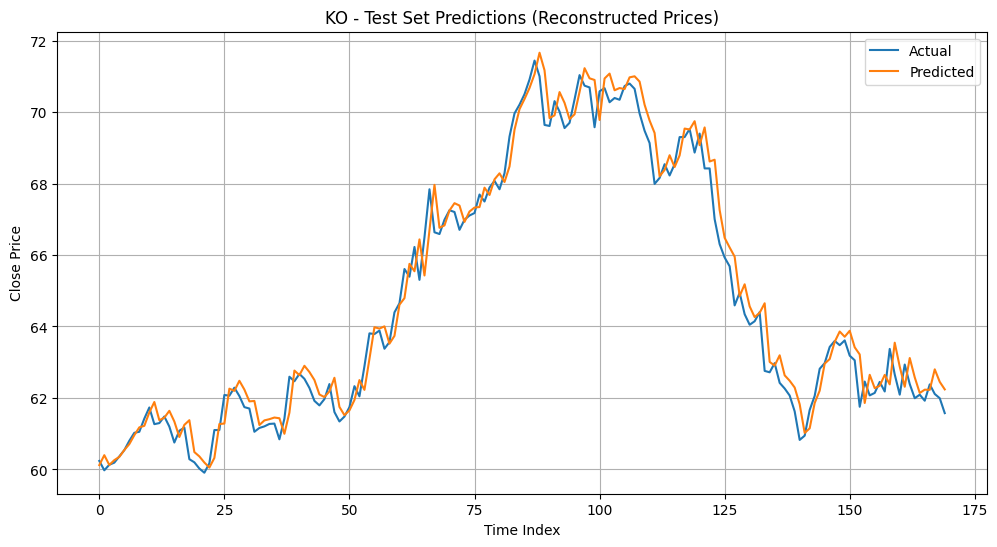

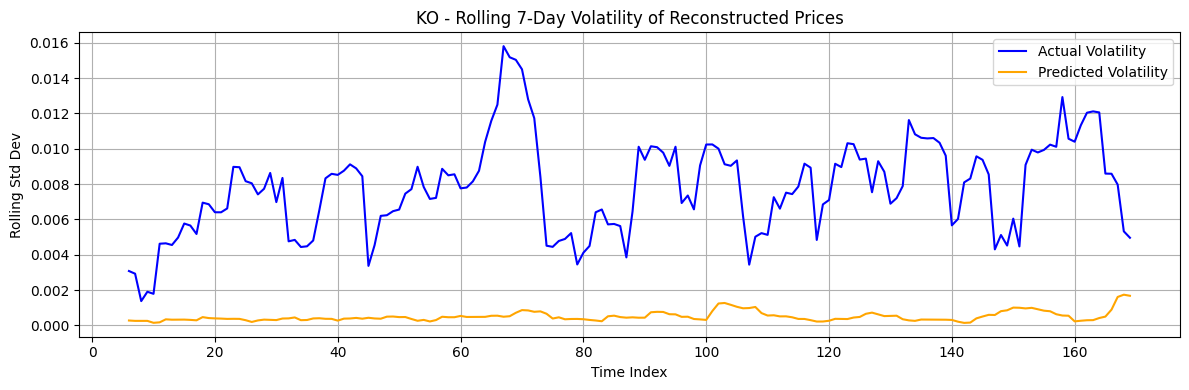

In [6]:
ko_model.eval()
preds, targets, prev_prices = [], [], []

with torch.no_grad():
    for xb, yb, p_tm1 in test_dl:
        xb = xb.to(device)
        y_pred = ko_model(xb).squeeze().cpu().numpy()

        preds.extend(y_pred)
        targets.extend(yb.numpy())
        prev_prices.extend(p_tm1.numpy())

preds = np.array(preds)
targets = np.array(targets)
prev_prices = np.array(prev_prices)

# Reconstruct actual prices
pred_prices = prev_prices * np.exp(preds)
true_prices = prev_prices * np.exp(targets)

print("Mean predicted return:", np.mean(preds))
print("Std of predicted return:", np.std(preds))

print("Mean actual return:", np.mean(targets))
print("Std of actual return:", np.std(targets))

# Metrics
rmse = np.sqrt(mean_squared_error(true_prices, pred_prices))
mae = mean_absolute_error(true_prices, pred_prices)
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE : {mae:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(true_prices, label="Actual")
plt.plot(pred_prices, label="Predicted")
plt.title(f"{stock.value} - Test Set Predictions (Reconstructed Prices)")
plt.xlabel("Time Index")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()

import pandas as pd
# --- Rolling Volatility (Price Level) ---
def rolling_std(x, window=7):
    return pd.Series(x).rolling(window=window).std().to_numpy()

window = 7  # can tweak
rolling_true_vol = rolling_std(targets, window)
rolling_pred_vol = rolling_std(preds, window)

# --- Plot Volatility ---
plt.figure(figsize=(12, 4))
plt.plot(rolling_true_vol, label="Actual Volatility", color="blue")
plt.plot(rolling_pred_vol, label="Predicted Volatility", color="orange")
plt.title(f"{stock.value} - Rolling {window}-Day Volatility of Reconstructed Prices")
plt.xlabel("Time Index")
plt.ylabel("Rolling Std Dev")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()